In [1]:
# ls

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('wave1_lip_dummies.csv', header=0, na_values=' ', index_col=0)
data.head()

,H1GI20,H1DA8,H1DA9,H1DA10,H1GH1,H1GH28,H1GH42,H1GH44,H1GH46,H1GH59A,...,BST90P13_3,BST90P24_1,BST90P24_2,BST90P24_3,BST90P24_4,BST90P24_5,BST90P24_6,BST90P26_1,BST90P26_2,BST90P26_3
AID,,,,,,,,,,,,,,,,,,,,,
57101310,11,33,4.0,0,4,5,4,5,5,6,...,0,0,0,0,0,0,1,0,0,1
57103869,12,24,6.0,7,4,2,4,4,5,6,...,1,0,1,0,0,0,0,0,1,0
57109625,8,14,7.0,3,1,2,2,4,4,5,...,0,0,1,0,0,0,0,0,0,1
57111071,8,35,12.0,2,2,4,3,3,3,5,...,0,0,1,0,0,0,0,0,0,1
57113943,9,10,5.0,4,3,4,3,4,5,6,...,1,0,1,0,0,0,0,1,0,0


In [4]:
data.shape

(5107, 500)

In [5]:
data.C_JOINT2.value_counts()

0    4686
1     421
Name: C_JOINT2, dtype: int64

#### Create CV Labels

In [6]:
data['cv_label'] = data.index

In [7]:
data.shape

(5107, 501)

In [8]:
# data.head()

In [9]:
target = data.C_JOINT2
target.head()

AID
57101310    1
57103869    0
57109625    0
57111071    0
57113943    0
Name: C_JOINT2, dtype: int64

In [10]:
del data['C_JOINT2']

In [11]:
del data['H1RP5'] #Question about pregnancy

In [12]:
del data['H1RP1']

In [13]:
# del data['H1RE1_4']

In [14]:
# del data['H1RE6']

In [15]:
del data['H1GI20']

In [16]:
# del data['H1MP2_1']

In [17]:
del data['H1SE3']

In [18]:
del data['H1RP4']

In [19]:
del data['H1RP6']

In [20]:
del data['H1SE2']

In [21]:
del data['H1SE1']

#### Oversample to balance classes

In [22]:
# NB: If you use this you'll need to add the package first
# conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [23]:
ros = RandomOverSampler(random_state=7)

In [24]:
data_res, target_res = ros.fit_sample(data, target)

In [25]:
data_res.shape

(9372, 492)

In [26]:
target_res.shape

(9372,)

In [27]:
# Double check to make sure class counts have been balanced
unique, counts = np.unique(target_res, return_counts=True)
dict(zip(unique, counts))

{0: 4686, 1: 4686}

#### Create training and testing sets

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_res, target_res, 
                                                    test_size=0.2, 
                                                    random_state=7)#, stratify=target_res)

In [29]:
last = X_train.shape[1]-1

In [30]:
cv_labels_train = X_train[:,[last]]
cv_labels_test = X_test[:,[last]]

In [31]:
X_train = np.delete(X_train, -1, 1)
X_test = np.delete(X_test, -1, 1)

In [32]:
# cv_labels = data_res[:,[499]] #Create array of cv_labels

In [33]:
# data_res = np.delete(data_res, -1, 1) #Delete cv_labels from data array

In [34]:
# data_res.shape

In [35]:
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import cross_val_predict

/Users/davidscroggins/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Cross-Validate predictions on new dataset

In [36]:
lkf_train = LabelKFold(cv_labels_train, n_folds=10)
lkf_test = LabelKFold(cv_labels_test, n_folds=10)

In [37]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [38]:
treeclf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [39]:
predicted = cross_val_predict(treeclf, X_train, y_train, cv=lkf_train)

In [40]:
print(classification_report(y_train, predicted))

             precision    recall  f1-score   support

          0       0.51      0.68      0.58      3723
          1       0.53      0.35      0.42      3774

avg / total       0.52      0.52      0.50      7497



#### Use GridSearchCV to tune parameters

In [41]:
# from sklearn.model_selection import GridSearchCV

In [42]:
# treeGridSearch = tree.DecisionTreeClassifier()

In [43]:
# parameters = {
#     'criterion' : ['entropy', 'gini'],
#     'max_depth' : np.arange(1, 11, 5),
#     'min_samples_leaf' : np.arange(1, 102, 20),
#     'min_samples_split' : np.arange(2, 103, 20)
# }

In [44]:
# gs = GridSearchCV(treeGridSearch, parameters, verbose=1, cv=lkf_train, 
#                   n_jobs=-1, scoring='recall')

In [45]:
# %time _ = gs.fit(X_train, y_train)

In [46]:
# gs.best_params_

#### Test best parameters

In [47]:
# # ten fold, scoring recall, more balanced scoring
# tree_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5,
#                                       min_samples_leaf =21, 
#                                        min_samples_split=102)

In [48]:
# five fold, scoring recall, best recall on minority class
tree_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                      min_samples_leaf =11, 
                                       min_samples_split=92)

In [49]:
# # five fold, scoring recall, best recall on minority class
# tree_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6,
#                                       min_samples_leaf =101, 
#                                        min_samples_split=2)

In [50]:
# tree_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6,
#                                       min_samples_leaf = 71, min_samples_split = 2)

In [51]:
tree_clf = tree_clf.fit(X_train, y_train)

In [52]:
# Repeat cross-validated testing
predicted = cross_val_predict(tree_clf, X_test, y_test, cv=lkf_test)

In [53]:
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.52      0.49      0.51       963
          1       0.49      0.51      0.50       912

avg / total       0.50      0.50      0.50      1875



In [54]:
cd graphics

/Users/davidscroggins/Google Drive/DePaul/csc478_machineLearning/csc478_project/csc478_initialModels/graphics


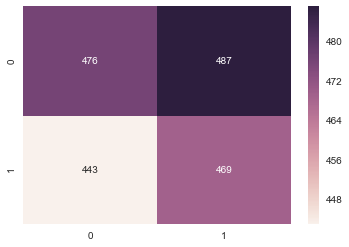

In [55]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
cm = confusion_matrix(y_test, predicted)
hm = sb.heatmap(cm, annot=True, fmt="d")
fig = hm.get_figure()
fig.savefig("heatMap_oversampling_lip")

In [56]:
#Get top 10 features
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = list(data)
top_indices = indices[:15]
for i in top_indices:
    print features_list[i]

H1GH28
H1TO16
H1DA9
BST90P09
H1EE12
H1TO9
H1DA1_2
H1EE6
H1TO2
H1FS6
H1RM4_6
H1GH19_2
H1GH20_0
H1GH19_6
H1GH19_4


#### Visualize tree

In [57]:
featureList = list(data)

In [58]:
from StringIO import StringIO
import pydotplus

In [59]:
tree.export_graphviz(tree_clf, out_file='tree.dot', feature_names=featureList)

In [60]:
dot_data = StringIO()
tree.export_graphviz(tree_clf, out_file=dot_data, feature_names=featureList)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('oversampling_lip.png')

True